In [16]:
str = "A 38-year-old Middle Eastern male presented to the emergency department with sudden onset dense right hemiparesis, 2 months of headache, right facial droop and aphasia.His background history included a previous ischaemic stroke 15 months ago treated in a different institution.At that time, he presented with a headache and dysphasia and a CT brain showed a left temporo-parietal infarct.By 6 months later, he had returned to his baseline of full functional independence on treatment with clopidogrel 75 mg once daily and atorvastatin 40 mg daily.\nOn this admission, CT brain showed a left M1 occlusion and the patient was treated with intravenous alteplase and thrombectomy.\nHis CT angiogram intracranial confirmed an acute occlusion of the M1 portion of the left middle cerebral artery and revealed two separate foci of soft plaques arising from the posterior wall of the origin of the left and right ICA with accompanying carotid webs on both sides ().His MRA carotids showed a haemorrhagic “plaque” at the origin of the left ICA but no high-grade ICA stenosis or any evidence of dissection ().Axial fat-saturated T1W MRI demonstrated a crescentic hyperintense signal at the posterior aspect of the origin of the left ICA consistent with haemorrhage within the known carotid web"

In [39]:
import pandas as pd

# Load the dataset from the CSV file
y = pd.read_csv('/Users/prashantronad/Documents/Hpcc/12k_Data/12koutput.csv')

print("Columns in the DataFrame:", y.columns)


# Convert `organ` and `symptom` columns to lowercase
y['organ'] = y['organ'].str.lower()
y['symptom'] = y['symptom'].str.lower()

# Sort the dataset by `organ` and `symptom`
z = y.sort_values(by=['organ', 'symptom']).reset_index(drop=True)

# Group by `symptom` and `organ` to calculate the count
final_ds = (
    z.groupby(['symptom', 'organ'])
    .size()
    .reset_index(name='cnt')  # Add a `cnt` column for the count
)

# Sort by `cnt` in descending order
f = final_ds.sort_values(by='cnt', ascending=False).reset_index(drop=True)

# Remove rows with `unspecified` organ or invalid symptom values
fs = f[
    (f['organ'] != 'unspecified') &
    (f['symptom'] != 'organ') &
    (f['symptom'] != 'symptom')
].reset_index(drop=True)

# Display the final DataFrame
print(fs)

Columns in the DataFrame: Index(['symptom', 'organ'], dtype='object')
              symptom                                organ  cnt
0            headache                                brain  328
1      abdominal pain                              abdomen  321
2            seizures                                brain  280
3         tachycardia                                heart  257
4             lesions                                brain  257
...               ...                                  ...  ...
50028       hyperemia  presphenoidal adenolymphoid tissues    1
50029       hyperemia                            right eye    1
50030       hyperemia                      synovial tissue    1
50031       hyperemic                          conjunctiva    1
50032       hyperemic                                 disk    1

[50033 rows x 3 columns]


In [23]:
def fHALF(str):

    import random
    import re

    l = []
    l.append(str)
    osl_shuffled = l

    print(len(osl_shuffled))


    import re

    # Assuming lis contains the text data
    dataset = osl_shuffled
    final_list_of_sentences = []

    # Compile the regex patterns once for efficiency
    sentence_splitter = re.compile(r'\.\s*')
    word_tokenizer = re.compile(r'\b[\w-]+\b')

    # Process each text in the dataset
    for text in dataset:
        # Split text into sentences and remove empty sentences
        sentences = [sentence.strip() + '.' for sentence in sentence_splitter.split(text) if sentence.strip()]
    
        # Tokenize, lowercase, and clean each sentence
        tokenized_sentences = [' '.join(word_tokenizer.findall(sentence.lower())) for sentence in sentences]
    
        # Append the cleaned sentences to the final list
        final_list_of_sentences.append(tokenized_sentences)

    print(len(final_list_of_sentences))

    for i in range(len(final_list_of_sentences)):
        if not final_list_of_sentences[i]:
            print('Empty')
        final_list_of_sentences[i] = [sentence for sentence in final_list_of_sentences[i] if sentence]

    final_list_of_sentences

    import torch
    import torch.nn as nn
    import re
    from torchcrf import CRF
    from transformers import AutoTokenizer, AutoModel
    from transformers import BertTokenizer, BertModel, BertConfig

    # Define BiLSTM and MOD classes
    class BiLSTM(nn.Module):
        def __init__(self):
            super(BiLSTM, self).__init__()
            self.input_size = 768
            self.hidden_size = 256
            self.num_layers = 2
            self.dropout = 0.3
            self.bilstm = nn.LSTM(input_size=self.input_size, hidden_size=128,
                                num_layers=self.num_layers, batch_first=True,
                                dropout=self.dropout, bidirectional=True)

        def forward(self, embeddings):
            lstm_out, _ = self.bilstm(embeddings)
            return lstm_out

    class MOD(nn.Module):
        def __init__(self, input_size, num_labels):
            super(MOD, self).__init__()
            self.bilstm = BiLSTM()
            self.linear = nn.Linear(256, num_labels)
            self.crf = CRF(num_labels)

        def forward(self, x):
            lstm_output = self.bilstm(x)
            embeddings = self.linear(lstm_output)
            return embeddings

    # Load BioBERT tokenizer and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config_path = r"/Users/prashantronad/Documents/Hpcc/NLP-pipeline-for-EHR/NLP/Utils/config.json"
    vocab_path = r"/Users/prashantronad/Documents/Hpcc/NLP-pipeline-for-EHR/NLP/Utils/vocab.txt"
    model_path = r"/Users/prashantronad/Documents/Hpcc/NLP-pipeline-for-EHR/NLP/Utils/pytorch_model.bin"

    config = BertConfig.from_pretrained(config_path)
    tokenizer = BertTokenizer.from_pretrained(vocab_path)
    biobert_model = BertModel.from_pretrained(model_path, config=config, local_files_only=True)

    # Load the trained model
    model = MOD(768, 6).to(device)  # Ensure model is on the same device
    model.load_state_dict(torch.load(r"/Users/prashantronad/Documents/Hpcc/NLP-pipeline-for-EHR/NLP/Utils/best_model.pth", map_location=device))
    model.eval()

    # Initialize lists for storing results
    all_symptoms_ALL = []
    symptoms_wout_duration_ALL = []
    symptom_with_organ_ALL = []
    new_dict_ALL = []

    organs_list = []
    # Assuming final_list_of_sentences is already defined
    for i in range(len(final_list_of_sentences)):    
        sentences = final_list_of_sentences[i]
        tsl_tokenized = []
    
        for sentence in sentences:
            tokens = re.findall(r'\b[\w-]+\b', sentence.lower())
            tsl_tokenized.append(tokens)
    
        vocab_test = []
        for sentence in tsl_tokenized:
            for token in sentence:
                if token not in vocab_test:
                    vocab_test.append(token)
    
        word_embeddings = []
        for word in vocab_test:
            tokens = tokenizer(word, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = biobert_model(**tokens)
            embedding = outputs.last_hidden_state[0][0]
            word_embeddings.append(embedding)

        word_embeddings_test = torch.stack(word_embeddings).to(device)
        sentence_embeddings_test = []
        each_sentence = []
    
        for k in range(len(tsl_tokenized)):
            each_word_embeddings_test = []
            for token in tsl_tokenized[k]:
                word_embedding_tensor_test = word_embeddings_test[vocab_test.index(token)]
                each_word_embeddings_test.append(word_embedding_tensor_test)
            sentence_embeddings_test.extend(each_word_embeddings_test)
            each_sentence.append(each_word_embeddings_test)

        pred = []
        for j, sentence in enumerate(each_sentence):
            if len(sentence) == 0:
                continue
            with torch.no_grad():
                print(i, j)
                # Stack the sentence tensors and move them to the device
                sentence_tensor = torch.stack(sentence).to(device).view(1, -1, 768)
                output = model(sentence_tensor)
                prediction = model.crf.decode(output)
                pred.append(prediction)

        # Create lists for different labels
        lis_1 = []
        lis_3 = []
        lis_4 = []
        lis_5 = []

        for i in range(len(pred)):
            l1 = {}
            l3 = {}
            l4 = {}
            l5 = {}
            prediction = pred[i]
            s = ''
            for k in range(len(prediction)):
                if prediction[k][0] != 0:
                    s += tsl_tokenized[i][k] + ' '
                elif k != 0 and prediction[k][0] == 0:
                    t = prediction[k-1][0]
                    if t != 0:
                        if t == 1:
                            l1[s.strip()] = k
                        elif t == 2:
                            l1[s.strip()] = k
                        elif t == 3:
                            l3[s.strip()] = k
                        elif t == 4:
                            l4[s.strip()] = k
                        elif t == 5:
                            l5[s.strip()] = k
                
                        s = ''

                    #store the organs in a set??
                    organs_list.append(list(l5.keys()))
            if prediction[-1][0] != 0:
                t = prediction[-1][0]
                if t == 1:
                    l1[s.strip()] = len(prediction)
                elif t == 2:
                    l1[s.strip()] = len(prediction)
                elif t == 3:
                    l3[s.strip()] = len(prediction)
                elif t == 4:
                    l4[s.strip()] = len(prediction)
                elif t == 5:
                    l5[s.strip()] = len(prediction)

            lis_1.append(l1)
            lis_3.append(l3)
            lis_4.append(l4)
            lis_5.append(l5)
    
        symptoms_wout_duration = []
        for l1 in lis_1:
            if l1:
                for key in l1.keys():
                    symptoms_wout_duration.append(key)
    
        new_dict = {}
        for i in range(len(lis_3)):
            if not lis_3[i]:
                #new_dict_ALL.append(new_dict)
                continue
            for key_3, value_3 in lis_3[i].items():
                closest_key = None
                minimum_difference = float('inf')
                for key_1, value_1 in lis_1[i].items():
                    difference = abs(value_3 - value_1)
                    if difference < minimum_difference:
                        minimum_difference = difference
                        closest_key = key_1
                new_dict[key_3] = closest_key

        all_symptoms_ALL.append(symptoms_wout_duration)
        symptoms_wout_duration_ALL.append(symptoms_wout_duration)
        new_dict_ALL.append(new_dict)

    print(all_symptoms_ALL)
    print(symptoms_wout_duration_ALL)
    print(symptom_with_organ_ALL)
    print(new_dict_ALL)
    print(lis_5)

    all_symptoms_ALL = [list(set(lst)) for lst in all_symptoms_ALL]
    print(symptoms_wout_duration_ALL)

    for i in symptoms_wout_duration_ALL:
        if 'headache' in i:
            print(True)


    hashset = set()
    for i in organs_list:
        if i:
            for j in i:
                hashset.add(j)


    print(hashset)

    import string
    import re

    # Create a set of common words to remove
    common_words = set(['a', 'and' 'an', 'the', 'is', 'are', 'was', 'were', 'of', 'in', 'to', 'for', 'and', 'or', 'but', 'with', 'on', 'at', 'as', 'by', 'for', 'with', 'as', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'as', 'until', 'while', 'as', 'until', 'while'])

    # Function to clean a single word
    def clean_word(word):
        # Remove punctuation and convert to lowercase
        word = word.lower().translate(str.maketrans('', '', string.punctuation))
        # Remove digits
        word = re.sub(r'\d+', '', word)
        return word.strip()

    # Clean the hashset
    cleaned_hashset = set()
    for item in hashset:
        # Split the item into words
        words = item.split()
        # Clean each word and keep only non-common words
        cleaned_words = [clean_word(word) for word in words if clean_word(word) and clean_word(word) not in common_words]
        # Join the cleaned words back together
        cleaned_item = ' '.join(cleaned_words)
        if cleaned_item:  # Only add non-empty items
            cleaned_hashset.add(cleaned_item)

    print("Cleaned hashset:", cleaned_hashset)

    hashset = cleaned_hashset

    #CHECK WHETHER A SYMPTOM IS PRESENT IN THE GIVEN SENTENCE
    #IF YES: LOOK FOR ORGANS IN THE SENTENCE AND IN THE (i + 1) AND (i - 1) SENTENCES
    #JUST EXTRACT THE PAIRS FOR N0W
    symp_to_organ_tentative = []
    for i in range(len(final_list_of_sentences)):   #EACH CASE
        for t in range(len(final_list_of_sentences[i])):    #SENTENCE IN EACH CASE

            #iterate through the symptoms_wout_duration_ALL list and check for it in i:
            for j in range(len(symptoms_wout_duration_ALL)):
                symptoms_in_case = symptoms_wout_duration_ALL[j]
                for k in range(len(symptoms_in_case)):
                    #CHECK FOR THE SYMPTOM IN i
                    symptom = symptoms_in_case[k]
                    if symptom in final_list_of_sentences[i][t]:
                        #SEARCH FOR AN ORGAN in (t, t + 1 and t - 1) AND JUST EXTRACT THE MAPPINGS
                        for q in hashset:
                            if q in final_list_of_sentences[i][t]:
                                #MAKE THE SYMPTOM - ORGAN PAIRS:
                                temp = []
                                temp.append(symptom)
                                temp.append(q)
                                symp_to_organ_tentative.append(temp)

                    if t- 1 >= 0 and symptom in final_list_of_sentences[i][t - 1] :
                        #SEARCH FOR AN ORGAN in (t, t + 1 and t - 1) AND JUST EXTRACT THE MAPPINGS
                        for q in hashset:
                            if q in final_list_of_sentences[i][t - 1]:
                                #MAKE THE SYMPTOM - ORGAN PAIRS:
                                temp = []
                                temp.append(symptom)
                                temp.append(q)

                    if t + 1 < len(final_list_of_sentences[i]) and symptom in final_list_of_sentences[i][t + 1] :
                        #SEARCH FOR AN ORGAN in (t, t + 1 and t - 1) AND JUST EXTRACT THE MAPPINGS
                        for q in hashset:
                            if q in final_list_of_sentences[i][t + 1]:
                                #MAKE THE SYMPTOM - ORGAN PAIRS:
                                temp = []
                                temp.append(symptom)
                                temp.append(q)


    s = []
    for i in symp_to_organ_tentative:
        if i not in s:
            s.append(i)
    print(s)
    symp_to_organ_tentative = s

    l = []
    for i in range(len(new_dict_ALL) - 1):
        if new_dict_ALL[i] != new_dict_ALL[i + 1]:
            l.append(new_dict_ALL[i])
    
    l.append(new_dict_ALL[len(new_dict_ALL) - 1])

    symptom_with_duration_ALL = l
    symptom_with_duration_ALL

    time_units = ['seconds', 'minutes', 'hours', 'days', 'months', 'years', 'decades']

    def replace_keys(data, time_units):
        new_data = []
        for item in data:
            new_item = {}
            for key, value in item.items():
                matched_word = next((unit for unit in time_units if unit in key), None)
                if matched_word and value is not None:
                    new_item[matched_word] = value
            new_data.append(new_item)
        return new_data

    updated_data = replace_keys(symptom_with_duration_ALL, time_units)
    print(updated_data)

    symptom_with_duration_ALL = updated_data
    symptom_with_duration_ALL

    symptom_duration_map = {}
    for duration_dict in symptom_with_duration_ALL:
        for duration, symptom in duration_dict.items():
            symptom_duration_map[symptom] = duration

    # Combine the lists to create the final output
    combined_list = []
    for symptom in symptoms_wout_duration_ALL[0]:
        # Get the duration for the current symptom, or 'nil duration' if not found
        duration = 'nil duration'
        for key in symptom_duration_map:
            if key in symptom:
                duration = symptom_duration_map[key]
                break

        # Find all organs associated with the symptom, or 'nil organ' if no association is found
        found_organ = False
        for symp, organ in symp_to_organ_tentative:
            if symptom == symp:
                combined_list.append([symptom, duration, organ])
                found_organ = True

        # If no organ was found for the symptom, add 'nil organ'
        if not found_organ:
            combined_list.append([symptom, duration, 'nil organ'])

    print(combined_list)

    duration_mapping = {
        'seconds': 2,
        'minutes': 3,
        'hours': 4,
        'days': 5,
        'months': 6,
        'years': 7,
        'decades': 8,
        'nil duration': 1
    }

    # Update the second element in each sublist
    for lis in combined_list:
        lis[1] = duration_mapping[lis[1]]

    # Convert each sublist to a tuple
    for i in range(len(combined_list)):
        combined_list[i] = tuple(combined_list[i])

    print(combined_list)
    print(type(combined_list[0]))

    return combined_list

In [19]:
import pandas as pd
def rec_filter(input_string, fs):
    # Use fHALF to parse the input string into a DataFrame
    symptoms_list = fHALF(input_string)
    symptoms_df = pd.DataFrame(symptoms_list, columns=['symptom', 'duration', 'organ'])
    symptoms_df['duration'] = symptoms_df['duration'].astype(int)  # Convert duration to integer

    # Perform INNER JOIN on fs and symptoms_df based on organ and symptom
    our_vals = pd.merge(fs, symptoms_df, on=['organ', 'symptom'], how='inner')

    # Group by organ to calculate the sum of cnt
    organ_group = our_vals.groupby('organ').agg(summation=('cnt', 'sum')).reset_index()

    # Calculate the denominator for p of organs (sum of all summations)
    denominator_for_p_of_organs = organ_group['summation'].sum()

    # Merge our_vals with organ_group to calculate naive_bayes_probability_factor
    our_vals = pd.merge(our_vals, organ_group, on='organ', how='left')
    our_vals['naive_bayes_probability_factor'] = our_vals['cnt'] / our_vals['summation']

    # Sort our_vals by naive_bayes_probability_factor in descending order
    our_vals_sorted = our_vals.sort_values(by='naive_bayes_probability_factor', ascending=False)

    # Group by symptom and select the row with the maximum naive_bayes_probability_factor
    final_group = our_vals_sorted.loc[
        our_vals_sorted.groupby('symptom')['naive_bayes_probability_factor'].idxmax()
    ].reset_index(drop=True)

    # Select relevant columns for the final DataFrame
    rec_filter_df = final_group[['symptom', 'duration', 'organ']]

    # Create a DataFrame for "nil organ" symptoms
    temp_organs = pd.DataFrame({'symptom': ['nil organ'], 'organ': ['nil organ']})

    # Perform FULL OUTER JOIN between rec_filter_df and temp_organs
    final_result = pd.merge(
        rec_filter_df, temp_organs, on='symptom', how='outer', suffixes=('', '_temp')
    ).fillna({'duration': 0, 'organ': 'nil organ'})

    # Convert the DataFrame to a list of tuples and return
    return list(final_result[['symptom', 'duration', 'organ']].itertuples(index=False, name=None))

# # Example Usage
# fs_data = {
#     'symptom': ['symp1', 'symp2', 'symp3', 'symp1'],
#     'organ': ['org1', 'org2', 'org3', 'org1'],
#     'cnt': [10, 20, 30, 15]
# }
# fs = pd.DataFrame(fs_data)

In [31]:
def func(combined_list):

    import networkx as nx
    import matplotlib.pyplot as plt

    # Create a new graph for the patient
    G = nx.Graph()

    # Add a central node for the patient
    patient_node = 'Patient 1'
    G.add_node(patient_node, label='Patient')

    # Add nodes for symptoms and organs, and connect them to the patient node
    for symptom, duration, organ in combined_list:
        # Add symptom node and connect to patient
        G.add_node(symptom, label='Symptom')
        G.add_edge(patient_node, symptom)

        # Add organ node if it is specified and connect to the symptom
        if organ != 'nil organ':
            G.add_node(organ, label='Organ')
            G.add_edge(symptom, organ)

        # Optional: Set edge weights based on symptom durations (if applicable)
        if duration != 'nil duration':
            G[patient_node][symptom]['weight'] = duration

    # Function to plot the graph
    def plot_graph(G):
        pos = nx.spring_layout(G, k=0.5, scale=2)  # Adjust k and scale for better spacing
        plt.figure(figsize=(12, 12))  # Adjust figure size for better display
        nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', alpha=0.7, edge_color='gray')
    
        # Draw edge labels and weights
        weights = nx.get_edge_attributes(G, 'weight')
        if weights:
            nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_color='green', font_size=8, label_pos=0.3)

        plt.title('Patient Symptom and Organ Network')
        plt.show()

    # Plot the graph
    plot_graph(G)




    from transformers import BertTokenizer, BertModel, BertConfig
    import torch
    import torch.nn as nn
    import re
    from torchcrf import CRF
    from transformers import AutoTokenizer, AutoModel
    from transformers import BertTokenizer, BertModel, BertConfig

    config_path = r"/Users/prashantronad/Documents/Hpcc/NLP-pipeline-for-EHR/NLP/Utils/config.json"
    vocab_path = r"/Users/prashantronad/Documents/Hpcc/NLP-pipeline-for-EHR/NLP/Utils/vocab.txt"
    model_path = r"/Users/prashantronad/Documents/Hpcc/NLP-pipeline-for-EHR/NLP/Utils/pytorch_model.bin"

    config = BertConfig.from_pretrained(config_path)
    tokenizer = BertTokenizer.from_pretrained(vocab_path)
    biobert_model = BertModel.from_pretrained(model_path, config=config, local_files_only=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    feature_matrices = []


    matrix = [None] * len(G.nodes())  # Initialize a list to store embeddings in the correct order

    edge_list = list(G.edges())
    unique_nodes = sorted(set(G.nodes()))  # Ensure all nodes are included and sorted

    node_mapping = {node: i for i, node in enumerate(unique_nodes)}  # Mapping nodes to indices

    for node in G.nodes():
        if node not in node_mapping:
            print(f"Node '{node}' not found in node_mapping.")
            continue
    
        print(node)
        text = node  # Text to be tokenized
        # inputs = tokenizer(text, return_tensors='pt').to(device)

        # with torch.no_grad():
        #     outputs = biobert_model(**inputs)
        #     embeddings = outputs.last_hidden_state

        # Averaging the embeddings
        #averaged_matrix = embeddings[0].mean(dim=0).view(1, -1)

        # Place the embedding in the correct row based on the node_mapping
    
        inputs = tokenizer(text, return_tensors='pt').to(device)

        with torch.no_grad():
            outputs = biobert_model(**inputs)
            embeddings = outputs.last_hidden_state

        # Averaging the embeddings
        averaged_matrix = embeddings[0].mean(dim=0).view(1, -1)
        matrix[node_mapping[node]] = averaged_matrix
    

    # Remove None entries (if any) and convert the list to a tensor
    matrix = torch.cat([m for m in matrix if m is not None], dim=0)  # (num_nodes, hidden_size)
    feature_matrices.append(matrix)

    print(feature_matrices)



    main_edge_list = []
    lis = []


    matrix = []
    print(G.nodes)

    edge_list = list(G.edges())
    unique_nodes = sorted(set(node for edge in edge_list for node in edge))  # Sort the unique nodes

    # Create a mapping from node labels to integers in a sorted order
    node_mapping = {node: i for i, node in enumerate(unique_nodes)}

    # Convert edge list to numeric representation
    numeric_edge_list = [[node_mapping[u], node_mapping[v]] for u, v in edge_list]

    # Create tensor and move to the appropriate device
    edge_tensor = torch.tensor(numeric_edge_list, dtype=torch.long).to(device)
    lis.append(edge_tensor)

    # Store the edge list in main_edge_list
    main_edge_list.append(edge_list)





    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch_geometric.nn import GCNConv, SortAggregation
    from torch_geometric.data import Data
    import torch.optim as optim
    import numpy as np
    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class GCN_SortPool_CNN(nn.Module):
        def __init__(self, in_channels, hidden_channels, out_channels, k):
            super(GCN_SortPool_CNN, self).__init__()
            self.conv1 = GCNConv(in_channels, hidden_channels)
            #self.conv2 = GCNConv(hidden_channels, hidden_channels)
            self.sort_pool = SortAggregation(k=k) #prioritizing nodes (dk what k is)
            self.cnn1d = nn.Conv1d(in_channels=hidden_channels, out_channels=32, kernel_size=2)
        
            # Calculate the correct input size for the fully connected layer
            cnn_output_size = 32 * (k - 1)  # Because kernel_size=2 reduces length by 1
            self.fc = nn.Linear(cnn_output_size, out_channels)
        
        def forward(self, x, edge_index):
            # GCN Layers
            x = F.relu(self.conv1(x, edge_index))
            #x = F.relu(self.conv2(x, edge_index))
        
            # SortPooling
            x = self.sort_pool(x, torch.zeros(x.size(0), dtype=torch.long, device=x.device))  # Create a dummy batch tensor
        
            # Reshape for 1D CNN
            x = x.view(x.size(0), -1, self.sort_pool.k)  # Reshape to (batch_size, hidden_channels, k)
        
            # 1D CNN
            x = F.relu(self.cnn1d(x))
            x = x.view(x.size(0), -1)  # Flatten
        
            # Fully Connected + Sigmoid
            x = self.fc(x)
            x = torch.sigmoid(x)  # Apply sigmoid activation
            return x

    # Load the model
    model = GCN_SortPool_CNN(in_channels=768, hidden_channels=32, out_channels=1, k=14).to(device)

    model.load_state_dict(torch.load(r"/Users/prashantronad/Documents/Hpcc/NLP-pipeline-for-EHR/NLP/Utils/gcn_sortpool_cnn.pth",map_location=torch.device('cpu')))
    model.eval()
    pred_1 = [0]
    pred_1_shuffled = [0]
    # Create a list of Data objects for the test data
    graphs = [Data(x=feature_matrices[i].to(device), edge_index=lis[i].to(device)) for i in range(len(feature_matrices))]
    print(len(pred_1))
    # Perform inference
    with torch.no_grad():
        predictions = []
        targets = []
        c=0
        for i, graph in enumerate(graphs):
            c+=1
            if c>44:
                break
            output = model(graph.x, graph.edge_index.view(2, -1))
            predicted = (output > 0.5).float()  # Convert probabilities to binary predictions
            predictions.append(predicted.cpu().numpy())  # Move output to CPU and convert to numpy array
            targets.append(pred_1_shuffled[i])  # Collect the targets

    # Convert lists to numpy arrays for easy comparison
    predictions = np.array(predictions).flatten()  # Flatten to match target shape
    targets = np.array(targets).flatten()  # Flatten to match prediction shape

    # Calculate number of correct predictions
    correct_predictions = np.sum(predictions == targets)
    total_predictions = len(targets)
    accuracy = correct_predictions / total_predictions

    # Output number of correct predictions, accuracy, and predictions
    print(f"Number of correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.4f}")

    q = -1
    for i, (pred, target) in enumerate(zip(predictions, targets)):
        print(f"Graph {i} - Prediction: {pred}, Target: {target}")
        q = pred

    s = ""
    if q == 0:
        s = "MRI NOT REQUIRED"
    elif q == 1:
        s = "MRI NEEDED NOW !!!"
    else:
        s = "PREDICTION_NEEDED"


    return [('', s)]

1
1


/Users/prashantronad/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1925: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_92021/3041863873.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are 

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
[['headache right facial droop and', 'headache', 'dysphasia', 'm1 occlusion', 'occlusion', 'plaques', 'plaque', 'stenosis', 'dissection', 'crescentic hyperintense signal', 'haemorrhage']]
[['headache right facial droop and', 'headache', 'dysphasia', 'm1 occlusion', 'occlusion', 'plaques', 'plaque', 'stenosis', 'dissection', 'crescentic hyperintense signal', 'haemorrhage']]
[]
[{'hemiparesis 2 months': 'headache right facial droop and', '15 months': None}]
[{}, {}, {'brain': 14}, {}, {'brain': 5}, {'intracranial': 4, 'the left middle cerebral artery': 18, 'posterior wall of the origin': 34, 'the left and right ica': 40, 'carotid webs': 44, 'both sides': 47}, {'mra carotids': 3, 'of': 11, 'ica': 14}, {'posterior aspect of': 14, 'left ica': 20, 'carotid': 27}]
[['headache right facial droop and', 'headache', 'dysphasia', 'm1 occlusion', 'occlusion', 'plaques', 'plaque', 'stenosis', 'dissection', 'crescentic hyperintense signal', 'haemorrhage']]
True
{'the l

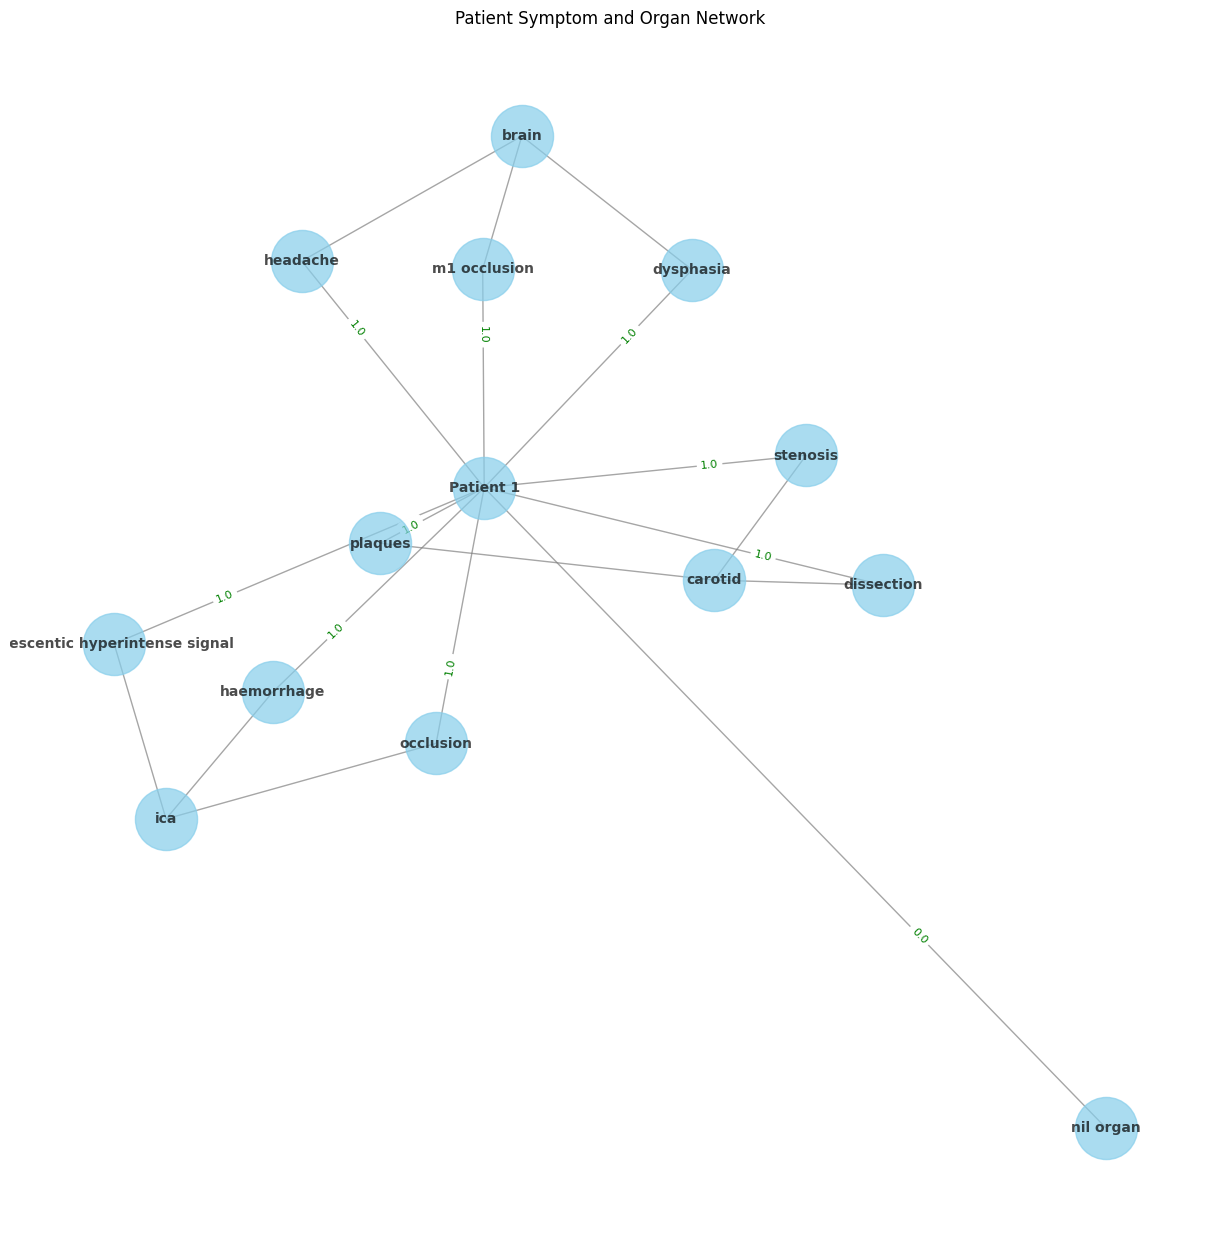

/Users/prashantronad/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1925: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


Patient 1
crescentic hyperintense signal
ica
dissection
carotid
dysphasia
brain
haemorrhage
headache
m1 occlusion
nil organ
occlusion
plaques
stenosis
[tensor([[ 0.3019, -0.0280, -0.2518,  ..., -0.0707,  0.2164, -0.1463],
        [ 0.2326, -0.1950, -0.2337,  ..., -0.6443,  0.5183,  0.0609],
        [-0.0572, -0.0111, -0.2339,  ..., -0.1582, -0.2785, -0.0588],
        ...,
        [ 0.0473,  0.0962, -0.1005,  ..., -0.1094,  0.1009, -0.1035],
        [ 0.0997, -0.1655,  0.1117,  ..., -0.5169,  0.6964, -0.5446],
        [ 0.2119, -0.0055,  0.1916,  ..., -0.2137,  0.0493, -0.1526]])]
['Patient 1', 'crescentic hyperintense signal', 'ica', 'dissection', 'carotid', 'dysphasia', 'brain', 'haemorrhage', 'headache', 'm1 occlusion', 'nil organ', 'occlusion', 'plaques', 'stenosis']
1
Number of correct predictions: 0
Accuracy: 0.0000
Graph 0 - Prediction: 1.0, Target: 0


/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_92021/3166025087.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"/Users/p

[('', 'MRI NEEDED NOW !!!')]

In [ ]:
t1 = func(rec_filter(str,fs))
t1



In [38]:
import pandas as pd

# Assuming FUNC_TEMP(med_data) and t1 are DataFrames
# Replace these with your actual DataFrames


df1 = rec_filter(str,fs)
df1 = pd.DataFrame(df1, columns=['symptom', 'duration', 'organ'])
df2 = pd.DataFrame(t1, columns=['symptom', 'result'])

# Perform a full outer join on the 'symptom' column
result = pd.merge(df1, df2, how='outer', left_on='symptom', right_on='symptom')

# Display the result
print(result)

1
1


/Users/prashantronad/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1925: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
/var/folders/_v/dz3m_2kn1pjgzx82_dbrsy680000gn/T/ipykernel_92021/3041863873.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are 

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
[['headache right facial droop and', 'headache', 'dysphasia', 'm1 occlusion', 'occlusion', 'plaques', 'plaque', 'stenosis', 'dissection', 'crescentic hyperintense signal', 'haemorrhage']]
[['headache right facial droop and', 'headache', 'dysphasia', 'm1 occlusion', 'occlusion', 'plaques', 'plaque', 'stenosis', 'dissection', 'crescentic hyperintense signal', 'haemorrhage']]
[]
[{'hemiparesis 2 months': 'headache right facial droop and', '15 months': None}]
[{}, {}, {'brain': 14}, {}, {'brain': 5}, {'intracranial': 4, 'the left middle cerebral artery': 18, 'posterior wall of the origin': 34, 'the left and right ica': 40, 'carotid webs': 44, 'both sides': 47}, {'mra carotids': 3, 'of': 11, 'ica': 14}, {'posterior aspect of': 14, 'left ica': 20, 'carotid': 27}]
[['headache right facial droop and', 'headache', 'dysphasia', 'm1 occlusion', 'occlusion', 'plaques', 'plaque', 'stenosis', 'dissection', 'crescentic hyperintense signal', 'haemorrhage']]
True
{'the l